# Lab: Titanic Survival Exploration with Decision Trees

## Getting Started
In this lab, you will see how decision trees work by implementing a decision tree in sklearn.

We'll start by loading the dataset and displaying some of its rows.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

# Set a random seed
import random
random.seed(42)

# Load the dataset
in_file = 'titanic_data.csv'
full_data = pd.read_csv(in_file)

# Print the first few entries of the RMS Titanic data
display(full_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Recall that these are the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  
Run the code cell below to remove **Survived** as a feature of the dataset and store it in `outcomes`.

In [2]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = full_data['Survived']
features_raw = full_data.drop('Survived', axis = 1)

# Show the new dataset with 'Survived' removed
display(features_raw.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The very same sample of the RMS Titanic data now shows the **Survived** feature removed from the DataFrame. Note that `data` (the passenger data) and `outcomes` (the outcomes of survival) are now *paired*. That means for any passenger `data.loc[i]`, they have the survival outcome `outcomes[i]`.

## Preprocessing the data

Now, let's do some data preprocessing. First, we'll remove the names of the passengers, and then one-hot encode the features.

One-Hot encoding is useful for changing over categorical data into numerical data, with each different option within a category changed into either a 0 or 1 in a separate *new* category as to whether it is that option or not (e.g. Queenstown port or not Queenstown port). Check out [this article](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) before continuing. 

**Question:** Why would it be a terrible idea to one-hot encode the data without removing the names?

**Answer:** If we one-hot encode the names columns, then there would be one column for each name, and the model would be learn the names of the survivors, and make predictions based on that. This would lead to some serious overfitting! 

In [3]:
# Removing the names
features_no_names = features_raw.drop(['Name'], axis=1)

# One-hot encoding
features = pd.get_dummies(features_no_names)

And now we'll fill in any blanks with zeroes.

In [4]:
features = features.fillna(0.0)
display(features.head())

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Ticket_110152,Ticket_110413,...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,1,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,3,26.0,0,0,7.9250,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## (TODO) Training the model

Now we're ready to train a model in sklearn. First, let's split the data into training and testing sets. Then we'll train the model on the training set.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2, random_state=42)

In [6]:
# Import the classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

# TODO: Define the classifier, and fit it to the data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Testing the model
Now, let's see how our model does, let's calculate the accuracy over both the training and the testing set.

In [7]:
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 1.0
The test accuracy is 0.815642458101


# Exercise: Improving the model

Ok, high training accuracy and a lower testing accuracy. We may be overfitting a bit.

So now it's your turn to shine! Train a new model, and try to specify some parameters in order to improve the testing accuracy, such as:
- `max_depth`
- `min_samples_leaf`
- `min_samples_split`

You can use your intuition, trial and error, or even better, feel free to use Grid Search!

**Challenge:** Try to get to 85% accuracy on the testing set. If you'd like a hint, take a look at the solutions notebook next.

In [8]:
# TODO: Train the model
model = DecisionTreeClassifier(max_depth=6, 
    min_samples_leaf=6, min_samples_split=10)
model.fit(X_train, y_train)

# TODO: Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# TODO: Calculate the accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.870786516854
The test accuracy is 0.854748603352


In [9]:
# Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(2, 10, 2),
    "min_samples_split": np.arange(2, 10, 2)
}
model = GridSearchCV(DecisionTreeClassifier(), cv=10,
    param_grid=param_grid, scoring='accuracy', n_jobs=4,
    return_train_score=True)
model.fit(features, outcomes)

print(f"The best set of parameters is: "
      f"{model.best_params_}")

The best set of parameters is: {'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 6}


In [10]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", 
    "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model.cv_results_)\
    .sort_values('mean_test_score', ascending=False)
cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "param_" in param_name:
        return param_name.rsplit("param_", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results.head()

,max_depth,min_samples_leaf,min_samples_split,mean_test_score,std_test_score,rank_test_score
42,6,6,6,0.814815,0.047425,1
40,6,6,2,0.812570,0.046032,2
41,6,6,4,0.812570,0.046032,2
43,6,6,8,0.812570,0.046032,2
36,6,4,2,0.810325,0.054402,5


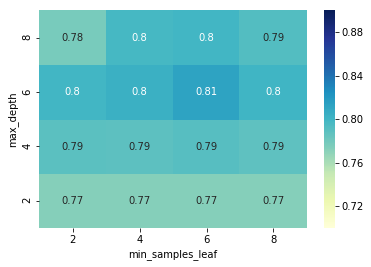

In [11]:
import seaborn as sns

pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["max_depth"],
    columns=["min_samples_leaf"])

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", 
    vmin=0.7, vmax=0.9)
ax.invert_yaxis()

In [13]:
# Train the model
model = DecisionTreeClassifier(max_depth=6, 
    min_samples_leaf=6, min_samples_split=6)
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.870786516854
The test accuracy is 0.854748603352
